In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(2, 30))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

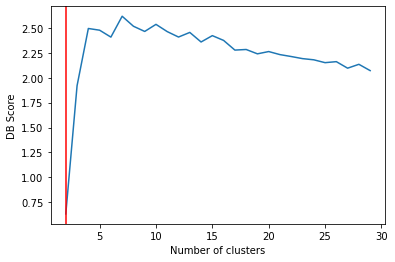

{0, 1}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

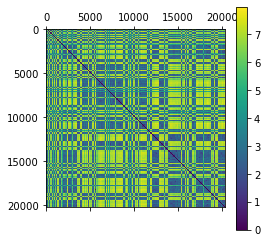

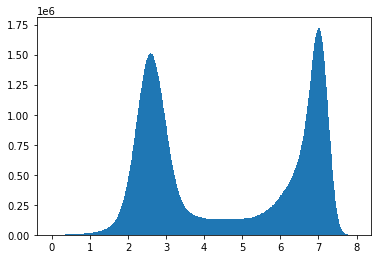

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

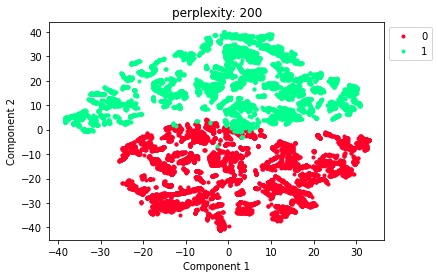

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9919676735820233


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.14984095094592334
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.7417127071823204
layer 4: 0.6799033149171271
layer 5: 0.5562845303867403
layer 6: 0.4017610497237569
layer 7: 0.25496374309392267
layer 8: 0.11202952348066299
Epoch: 00 | Batch: 000 / 011 | Total loss: 0.705 | Reg loss: 0.017 | Tree loss: 0.705 | Accuracy: 0.551000 | 6.98 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 0.702 | Reg loss: 0.017 | Tree loss: 0.702 | Accuracy: 0.509000 | 4.138 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 0.697 | Reg loss: 0.017 | Tree loss: 0.697 | Accuracy: 0.531500 | 3.197 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 0.696 | Reg loss: 0.016 | Tree loss: 0.696 | Accuracy: 0.535000 | 2.725 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 0.694 | Reg loss: 0.016 | Tree loss: 0.694 | Accuracy: 0.560500 | 2.447 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 0.691 | Reg loss: 0.015 | Tree loss: 0.691 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 0.695 | Reg loss: 0.012 | Tree loss: 0.695 | Accuracy: 0.650000 | 1.939 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 0.693 | Reg loss: 0.012 | Tree loss: 0.693 | Accuracy: 0.656000 | 1.924 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 0.692 | Reg loss: 0.012 | Tree loss: 0.692 | Accuracy: 0.677000 | 1.913 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 0.694 | Reg loss: 0.012 | Tree loss: 0.694 | Accuracy: 0.664500 | 1.903 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 0.686 | Reg loss: 0.012 | Tree loss: 0.686 | Accuracy: 0.687000 | 1.894 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 0.685 | Reg loss: 0.012 | Tree loss: 0.685 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 0.692 | Reg loss: 0.012 | Tree loss: 0.692 | Accuracy: 0.674000 | 1.775 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 0.695 | Reg loss: 0.012 | Tree loss: 0.695 | Accuracy: 0.632000 | 1.769 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 0.691 | Reg loss: 0.012 | Tree loss: 0.691 | Accuracy: 0.658000 | 1.762 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 0.691 | Reg loss: 0.012 | Tree loss: 0.691 | Accuracy: 0.663000 | 1.756 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 0.692 | Reg loss: 0.012 | Tree loss: 0.692 | Accuracy: 0.677500 | 1.75 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 0.686 | Reg loss: 0.012 | Tree loss: 0.686 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 0.686 | Reg loss: 0.012 | Tree loss: 0.686 | Accuracy: 0.672000 | 1.835 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 0.683 | Reg loss: 0.012 | Tree loss: 0.683 | Accuracy: 0.705500 | 1.83 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 0.680 | Reg loss: 0.012 | Tree loss: 0.680 | Accuracy: 0.709500 | 1.826 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 0.669 | Reg loss: 0.012 | Tree loss: 0.669 | Accuracy: 0.717500 | 1.821 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 0.669 | Reg loss: 0.012 | Tree loss: 0.669 | Accuracy: 0.639500 | 1.817 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 0.664 | Reg loss: 0.012 | Tree loss: 0.664 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 0.662 | Reg loss: 0.012 | Tree loss: 0.662 | Accuracy: 0.734500 | 1.783 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 0.664 | Reg loss: 0.012 | Tree loss: 0.664 | Accuracy: 0.707500 | 1.781 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 0.651 | Reg loss: 0.013 | Tree loss: 0.651 | Accuracy: 0.713500 | 1.779 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 0.646 | Reg loss: 0.013 | Tree loss: 0.646 | Accuracy: 0.669500 | 1.777 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 0.654 | Reg loss: 0.013 | Tree loss: 0.654 | Accuracy: 0.617000 | 1.775 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 0.642 | Reg loss: 0.013 | Tree loss: 0.642 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 0.638 | Reg loss: 0.014 | Tree loss: 0.638 | Accuracy: 0.711500 | 1.76 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 0.640 | Reg loss: 0.014 | Tree loss: 0.640 | Accuracy: 0.684000 | 1.758 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 0.626 | Reg loss: 0.014 | Tree loss: 0.626 | Accuracy: 0.727500 | 1.755 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 0.616 | Reg loss: 0.014 | Tree loss: 0.616 | Accuracy: 0.711500 | 1.753 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 0.611 | Reg loss: 0.014 | Tree loss: 0.611 | Accuracy: 0.688500 | 1.751 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 0.620 | Reg loss: 0.014 | Tree loss: 0.620 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 0.623 | Reg loss: 0.015 | Tree loss: 0.623 | Accuracy: 0.674500 | 1.737 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.015 | Tree loss: 0.602 | Accuracy: 0.713500 | 1.736 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 0.585 | Reg loss: 0.015 | Tree loss: 0.585 | Accuracy: 0.725500 | 1.734 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 0.580 | Reg loss: 0.015 | Tree loss: 0.580 | Accuracy: 0.701000 | 1.734 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 0.590 | Reg loss: 0.015 | Tree loss: 0.590 | Accuracy: 0.660000 | 1.733 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 0.587 | Reg loss: 0.015 | Tree loss: 0.587 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 0.612 | Reg loss: 0.016 | Tree loss: 0.612 | Accuracy: 0.696000 | 1.721 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 0.589 | Reg loss: 0.016 | Tree loss: 0.589 | Accuracy: 0.708000 | 1.72 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 0.570 | Reg loss: 0.016 | Tree loss: 0.570 | Accuracy: 0.734000 | 1.718 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 0.568 | Reg loss: 0.016 | Tree loss: 0.568 | Accuracy: 0.712500 | 1.716 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 0.558 | Reg loss: 0.016 | Tree loss: 0.558 | Accuracy: 0.725000 | 1.715 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 0.555 | Reg loss: 0.016 | Tree loss: 0.555 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 0.612 | Reg loss: 0.017 | Tree loss: 0.612 | Accuracy: 0.697000 | 1.715 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 0.594 | Reg loss: 0.017 | Tree loss: 0.594 | Accuracy: 0.685000 | 1.715 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.017 | Tree loss: 0.561 | Accuracy: 0.711500 | 1.714 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.017 | Tree loss: 0.532 | Accuracy: 0.770500 | 1.714 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 0.527 | Reg loss: 0.017 | Tree loss: 0.527 | Accuracy: 0.794000 | 1.713 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 0.544 | Reg loss: 0.017 | Tree loss: 0.544 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 0.591 | Reg loss: 0.017 | Tree loss: 0.591 | Accuracy: 0.685500 | 1.704 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 0.590 | Reg loss: 0.017 | Tree loss: 0.590 | Accuracy: 0.701000 | 1.702 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.017 | Tree loss: 0.561 | Accuracy: 0.715500 | 1.701 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.017 | Tree loss: 0.532 | Accuracy: 0.771000 | 1.7 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 0.514 | Reg loss: 0.017 | Tree loss: 0.514 | Accuracy: 0.797000 | 1.698 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 0.511 | Reg loss: 0.017 | Tree loss: 0.511 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 0.573 | Reg loss: 0.018 | Tree loss: 0.573 | Accuracy: 0.708500 | 1.7 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 0.567 | Reg loss: 0.018 | Tree loss: 0.567 | Accuracy: 0.733500 | 1.7 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 0.534 | Reg loss: 0.018 | Tree loss: 0.534 | Accuracy: 0.757000 | 1.699 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 0.502 | Reg loss: 0.018 | Tree loss: 0.502 | Accuracy: 0.794500 | 1.698 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 0.496 | Reg loss: 0.018 | Tree loss: 0.496 | Accuracy: 0.818500 | 1.697 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.018 | Tree loss: 0.497 | Accur

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 0.556 | Reg loss: 0.018 | Tree loss: 0.556 | Accuracy: 0.738500 | 1.687 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 0.547 | Reg loss: 0.018 | Tree loss: 0.547 | Accuracy: 0.761500 | 1.686 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 0.532 | Reg loss: 0.018 | Tree loss: 0.532 | Accuracy: 0.765000 | 1.686 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 0.512 | Reg loss: 0.018 | Tree loss: 0.512 | Accuracy: 0.780500 | 1.685 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 0.494 | Reg loss: 0.018 | Tree loss: 0.494 | Accuracy: 0.798500 | 1.685 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 0.480 | Reg loss: 0.018 | Tree loss: 0.480 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.018 | Tree loss: 0.541 | Accuracy: 0.749500 | 1.691 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.525 | Reg loss: 0.018 | Tree loss: 0.525 | Accuracy: 0.773500 | 1.691 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.523 | Reg loss: 0.018 | Tree loss: 0.523 | Accuracy: 0.760500 | 1.69 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.503 | Reg loss: 0.018 | Tree loss: 0.503 | Accuracy: 0.764000 | 1.689 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.483 | Reg loss: 0.018 | Tree loss: 0.483 | Accuracy: 0.800000 | 1.688 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 0.477 | Reg loss: 0.018 | Tree loss: 0.477 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 0.526 | Reg loss: 0.018 | Tree loss: 0.526 | Accuracy: 0.747000 | 1.681 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 0.514 | Reg loss: 0.018 | Tree loss: 0.514 | Accuracy: 0.758000 | 1.681 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.018 | Tree loss: 0.512 | Accuracy: 0.766000 | 1.681 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 0.489 | Reg loss: 0.018 | Tree loss: 0.489 | Accuracy: 0.783000 | 1.68 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.472 | Reg loss: 0.018 | Tree loss: 0.472 | Accuracy: 0.809500 | 1.68 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.018 | Tree loss: 0.462 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 0.510 | Reg loss: 0.019 | Tree loss: 0.510 | Accuracy: 0.770000 | 1.684 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 0.513 | Reg loss: 0.019 | Tree loss: 0.513 | Accuracy: 0.761500 | 1.684 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.497 | Reg loss: 0.019 | Tree loss: 0.497 | Accuracy: 0.757500 | 1.683 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.493 | Reg loss: 0.019 | Tree loss: 0.493 | Accuracy: 0.770500 | 1.682 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.481 | Reg loss: 0.019 | Tree loss: 0.481 | Accuracy: 0.790000 | 1.681 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.467 | Reg loss: 0.019 | Tree loss: 0.467 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 0.518 | Reg loss: 0.019 | Tree loss: 0.518 | Accuracy: 0.740500 | 1.677 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 0.531 | Reg loss: 0.019 | Tree loss: 0.531 | Accuracy: 0.740000 | 1.677 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 0.513 | Reg loss: 0.019 | Tree loss: 0.513 | Accuracy: 0.741000 | 1.676 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 0.482 | Reg loss: 0.019 | Tree loss: 0.482 | Accuracy: 0.786000 | 1.676 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 0.459 | Reg loss: 0.019 | Tree loss: 0.459 | Accuracy: 0.813500 | 1.676 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.019 | Tree loss: 0.455 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.019 | Tree loss: 0.505 | Accuracy: 0.769500 | 1.675 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 0.508 | Reg loss: 0.019 | Tree loss: 0.508 | Accuracy: 0.749000 | 1.674 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 0.497 | Reg loss: 0.019 | Tree loss: 0.497 | Accuracy: 0.760000 | 1.674 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 0.479 | Reg loss: 0.019 | Tree loss: 0.479 | Accuracy: 0.784500 | 1.673 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 0.457 | Reg loss: 0.019 | Tree loss: 0.457 | Accuracy: 0.816500 | 1.673 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.441 | Reg loss: 0.019 | Tree loss: 0.441 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 0.515 | Reg loss: 0.019 | Tree loss: 0.515 | Accuracy: 0.746500 | 1.672 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 0.492 | Reg loss: 0.019 | Tree loss: 0.492 | Accuracy: 0.761500 | 1.672 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 0.479 | Reg loss: 0.019 | Tree loss: 0.479 | Accuracy: 0.790500 | 1.671 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 0.467 | Reg loss: 0.019 | Tree loss: 0.467 | Accuracy: 0.805500 | 1.671 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.443 | Reg loss: 0.019 | Tree loss: 0.443 | Accuracy: 0.824500 | 1.671 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.019 | Tree loss: 0.455 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.019 | Tree loss: 0.500 | Accuracy: 0.748000 | 1.672 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 0.502 | Reg loss: 0.019 | Tree loss: 0.502 | Accuracy: 0.763500 | 1.671 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 0.469 | Reg loss: 0.019 | Tree loss: 0.469 | Accuracy: 0.784500 | 1.671 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 0.472 | Reg loss: 0.019 | Tree loss: 0.472 | Accuracy: 0.794000 | 1.67 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.435 | Reg loss: 0.019 | Tree loss: 0.435 | Accuracy: 0.831500 | 1.669 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.019 | Tree loss: 0.459 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 0.501 | Reg loss: 0.019 | Tree loss: 0.501 | Accuracy: 0.758000 | 1.669 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 0.489 | Reg loss: 0.019 | Tree loss: 0.489 | Accuracy: 0.767000 | 1.669 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.498 | Reg loss: 0.019 | Tree loss: 0.498 | Accuracy: 0.767000 | 1.669 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.452 | Reg loss: 0.019 | Tree loss: 0.452 | Accuracy: 0.801000 | 1.669 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.447 | Reg loss: 0.019 | Tree loss: 0.447 | Accuracy: 0.814500 | 1.668 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.447 | Reg loss: 0.019 | Tree loss: 0.447 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 0.513 | Reg loss: 0.019 | Tree loss: 0.513 | Accuracy: 0.754500 | 1.667 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 0.505 | Reg loss: 0.019 | Tree loss: 0.505 | Accuracy: 0.761000 | 1.667 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.483 | Reg loss: 0.019 | Tree loss: 0.483 | Accuracy: 0.782000 | 1.667 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.457 | Reg loss: 0.019 | Tree loss: 0.457 | Accuracy: 0.803000 | 1.666 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.434 | Reg loss: 0.019 | Tree loss: 0.434 | Accuracy: 0.839500 | 1.666 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.435 | Reg loss: 0.019 | Tree loss: 0.4

Epoch: 104 | Batch: 010 / 011 | Total loss: 0.418 | Reg loss: 0.019 | Tree loss: 0.418 | Accuracy: 0.846416 | 1.661 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 0.504 | Reg loss: 0.019 | Tree loss: 0.504 | Accuracy: 0.765000 | 1.667 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.498 | Reg loss: 0.019 | Tree loss: 0.498 | Accuracy: 0.758500 | 1.667 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.493 | Reg loss: 0.019 | Tree loss: 0.493 | Accuracy: 0.763500 | 1.666 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.458 | Reg loss: 0.019 | Tree loss: 0.458 | Accuracy: 0.788500 | 1.666 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.439 | Reg loss: 0.019 | Tree loss: 0.4

Epoch: 109 | Batch: 009 / 011 | Total loss: 0.440 | Reg loss: 0.020 | Tree loss: 0.440 | Accuracy: 0.803500 | 1.663 sec/iter
Epoch: 109 | Batch: 010 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.832765 | 1.662 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 0.486 | Reg loss: 0.020 | Tree loss: 0.486 | Accuracy: 0.783000 | 1.664 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 0.495 | Reg loss: 0.020 | Tree loss: 0.495 | Accuracy: 0.773000 | 1.664 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.481 | Reg loss: 0.020 | Tree loss: 0.481 | Accuracy: 0.769500 | 1.663 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.462 | Reg loss: 0.020 | Tree loss: 0.4

Epoch: 114 | Batch: 008 / 011 | Total loss: 0.453 | Reg loss: 0.020 | Tree loss: 0.453 | Accuracy: 0.783500 | 1.661 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 0.458 | Reg loss: 0.020 | Tree loss: 0.458 | Accuracy: 0.775500 | 1.66 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 0.412 | Reg loss: 0.020 | Tree loss: 0.412 | Accuracy: 0.832765 | 1.66 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.497 | Reg loss: 0.020 | Tree loss: 0.497 | Accuracy: 0.764500 | 1.665 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.514 | Reg loss: 0.020 | Tree loss: 0.514 | Accuracy: 0.747500 | 1.665 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.495 | Reg loss: 0.020 | Tree loss: 0.495

Epoch: 119 | Batch: 007 / 011 | Total loss: 0.450 | Reg loss: 0.020 | Tree loss: 0.450 | Accuracy: 0.797000 | 1.66 sec/iter
Epoch: 119 | Batch: 008 / 011 | Total loss: 0.446 | Reg loss: 0.020 | Tree loss: 0.446 | Accuracy: 0.791500 | 1.659 sec/iter
Epoch: 119 | Batch: 009 / 011 | Total loss: 0.437 | Reg loss: 0.020 | Tree loss: 0.437 | Accuracy: 0.791000 | 1.659 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 0.433 | Reg loss: 0.020 | Tree loss: 0.433 | Accuracy: 0.784983 | 1.658 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.494 | Reg loss: 0.020 | Tree loss: 0.494 | Accuracy: 0.766500 | 1.661 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.507 | Reg loss: 0.020 | Tree loss: 0.50

Epoch: 124 | Batch: 006 / 011 | Total loss: 0.466 | Reg loss: 0.020 | Tree loss: 0.466 | Accuracy: 0.783000 | 1.661 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 0.438 | Reg loss: 0.020 | Tree loss: 0.438 | Accuracy: 0.799500 | 1.66 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 0.430 | Reg loss: 0.020 | Tree loss: 0.430 | Accuracy: 0.806000 | 1.66 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.020 | Tree loss: 0.420 | Accuracy: 0.823500 | 1.659 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.430 | Reg loss: 0.020 | Tree loss: 0.430 | Accuracy: 0.860068 | 1.659 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.502 | Reg loss: 0.020 | Tree loss: 0.502

Epoch: 129 | Batch: 005 / 011 | Total loss: 0.435 | Reg loss: 0.020 | Tree loss: 0.435 | Accuracy: 0.806500 | 1.663 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.020 | Tree loss: 0.437 | Accuracy: 0.804500 | 1.663 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.020 | Tree loss: 0.439 | Accuracy: 0.809500 | 1.662 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.446 | Reg loss: 0.020 | Tree loss: 0.446 | Accuracy: 0.791500 | 1.662 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.452 | Reg loss: 0.020 | Tree loss: 0.452 | Accuracy: 0.785000 | 1.662 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.398 | Reg loss: 0.020 | Tree loss: 0.398 | Accuracy: 0.836177 | 1.661 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 134 | Batch: 004 / 011 | Total loss: 0.420 | Reg loss: 0.020 | Tree loss: 0.420 | Accuracy: 0.828500 | 1.669 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.020 | Tree loss: 0.436 | Accuracy: 0.822500 | 1.669 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.449 | Reg loss: 0.020 | Tree loss: 0.449 | Accuracy: 0.790000 | 1.668 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.458 | Reg loss: 0.020 | Tree loss: 0.458 | Accuracy: 0.777000 | 1.668 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.454 | Reg loss: 0.020 | Tree loss: 0.454 | Accuracy: 0.783000 | 1.667 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.419 | Reg loss: 0.020 | Tree loss: 0.419 | Accuracy: 0.811500 | 1.667 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 0.459 | Reg loss: 0.020 | Tree loss: 0.459 | Accuracy: 0.802048 | 1.666 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 139 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.020 | Tree loss: 0.459 | Accuracy: 0.802000 | 1.666 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.020 | Tree loss: 0.429 | Accuracy: 0.827500 | 1.666 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.020 | Tree loss: 0.424 | Accuracy: 0.852000 | 1.666 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.020 | Tree loss: 0.427 | Accuracy: 0.812500 | 1.666 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.441 | Reg loss: 0.020 | Tree loss: 0.441 | Accuracy: 0.787500 | 1.665 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.439 | Reg loss: 0.020 | Tree loss: 0.439 | Accuracy: 0.802000 | 1.665 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.458 | Reg loss: 0.020 | Tree loss: 0.458 | Accuracy: 0.785000 | 1.664 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.412 | Reg loss: 0.020 | Tree loss: 0.412 | Accuracy: 0.805461 | 1.664 sec/iter


Epoch: 144 | Batch: 002 / 011 | Total loss: 0.485 | Reg loss: 0.020 | Tree loss: 0.485 | Accuracy: 0.778000 | 1.665 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.453 | Reg loss: 0.020 | Tree loss: 0.453 | Accuracy: 0.802500 | 1.665 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 0.420 | Reg loss: 0.020 | Tree loss: 0.420 | Accuracy: 0.837000 | 1.665 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.020 | Tree loss: 0.415 | Accuracy: 0.850000 | 1.664 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.020 | Tree loss: 0.418 | Accuracy: 0.821500 | 1.664 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.020 | Tree loss: 0.445 | Accuracy: 0.796000 | 1.663 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.456 | Reg loss: 0.020 | Tree loss: 0.456 | Accuracy: 0.774500 | 1.663 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.428 | Reg loss: 0.020 | Tree loss: 0.428 | Accuracy: 0.807000 | 1.663 sec/iter


Epoch: 149 | Batch: 001 / 011 | Total loss: 0.489 | Reg loss: 0.020 | Tree loss: 0.489 | Accuracy: 0.780500 | 1.664 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 0.493 | Reg loss: 0.020 | Tree loss: 0.493 | Accuracy: 0.771500 | 1.664 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 0.461 | Reg loss: 0.020 | Tree loss: 0.461 | Accuracy: 0.810500 | 1.664 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 0.439 | Reg loss: 0.020 | Tree loss: 0.439 | Accuracy: 0.818000 | 1.664 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 0.435 | Reg loss: 0.020 | Tree loss: 0.435 | Accuracy: 0.821000 | 1.663 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.807500 | 1.663 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.020 | Tree loss: 0.445 | Accuracy: 0.794000 | 1.663 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.431 | Reg loss: 0.020 | Tree loss: 0.431 | Accuracy: 0.797500 | 1.663 sec/iter


Epoch: 154 | Batch: 000 / 011 | Total loss: 0.485 | Reg loss: 0.020 | Tree loss: 0.485 | Accuracy: 0.782000 | 1.664 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.020 | Tree loss: 0.486 | Accuracy: 0.778000 | 1.664 sec/iter
Epoch: 154 | Batch: 002 / 011 | Total loss: 0.485 | Reg loss: 0.020 | Tree loss: 0.485 | Accuracy: 0.781000 | 1.664 sec/iter
Epoch: 154 | Batch: 003 / 011 | Total loss: 0.469 | Reg loss: 0.020 | Tree loss: 0.469 | Accuracy: 0.790500 | 1.663 sec/iter
Epoch: 154 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.020 | Tree loss: 0.429 | Accuracy: 0.830500 | 1.663 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 0.427 | Reg loss: 0.020 | Tree loss: 0.427 | Accuracy: 0.838500 | 1.663 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.020 | Tree loss: 0.439 | Accuracy: 0.803500 | 1.662 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.020 | Tree loss: 0.429 | Accuracy: 0.806000 | 1.662 sec/iter


Epoch: 159 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.020 | Tree loss: 0.483 | Accuracy: 0.774500 | 1.663 sec/iter
Epoch: 159 | Batch: 001 / 011 | Total loss: 0.481 | Reg loss: 0.020 | Tree loss: 0.481 | Accuracy: 0.772000 | 1.663 sec/iter
Epoch: 159 | Batch: 002 / 011 | Total loss: 0.465 | Reg loss: 0.020 | Tree loss: 0.465 | Accuracy: 0.780500 | 1.663 sec/iter
Epoch: 159 | Batch: 003 / 011 | Total loss: 0.453 | Reg loss: 0.020 | Tree loss: 0.453 | Accuracy: 0.798000 | 1.662 sec/iter
Epoch: 159 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.020 | Tree loss: 0.416 | Accuracy: 0.839500 | 1.662 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 0.434 | Reg loss: 0.020 | Tree loss: 0.434 | Accuracy: 0.800000 | 1.662 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 0.430 | Reg loss: 0.020 | Tree loss: 0.430 | Accuracy: 0.813500 | 1.662 sec/iter
Epoch: 159 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.020 | Tree loss: 0.422 | Accuracy: 0.807000 | 1.661 sec/iter


Epoch: 164 | Batch: 000 / 011 | Total loss: 0.487 | Reg loss: 0.020 | Tree loss: 0.487 | Accuracy: 0.774000 | 1.661 sec/iter
Epoch: 164 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.020 | Tree loss: 0.475 | Accuracy: 0.782000 | 1.661 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 0.474 | Reg loss: 0.020 | Tree loss: 0.474 | Accuracy: 0.786000 | 1.661 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.020 | Tree loss: 0.443 | Accuracy: 0.812000 | 1.66 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.020 | Tree loss: 0.427 | Accuracy: 0.820500 | 1.66 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.020 | Tree loss: 0.428 | Accuracy: 0.804500 | 1.66 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.020 | Tree loss: 0.439 | Accuracy: 0.786500 | 1.659 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.020 | Tree loss: 0.436 | Accuracy: 0.802500 | 1.659 sec/iter
Epo

layer 8: 0.9723756906077345
Epoch: 169 | Batch: 000 / 011 | Total loss: 0.487 | Reg loss: 0.020 | Tree loss: 0.487 | Accuracy: 0.786000 | 1.661 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.020 | Tree loss: 0.479 | Accuracy: 0.788000 | 1.661 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 0.469 | Reg loss: 0.020 | Tree loss: 0.469 | Accuracy: 0.796000 | 1.661 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.020 | Tree loss: 0.444 | Accuracy: 0.815500 | 1.661 sec/iter
Epoch: 169 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.020 | Tree loss: 0.427 | Accuracy: 0.815500 | 1.661 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.020 | Tree loss: 0.424 | Accuracy: 0.831000 | 1.66 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 0.441 | Reg loss: 0.020 | Tree loss: 0.441 | Accuracy: 0.800500 | 1.66 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.020 | Tree loss: 0.426 | Accuracy: 

Epoch: 174 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.020 | Tree loss: 0.483 | Accuracy: 0.789500 | 1.66 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 0.498 | Reg loss: 0.020 | Tree loss: 0.498 | Accuracy: 0.777500 | 1.659 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 0.483 | Reg loss: 0.020 | Tree loss: 0.483 | Accuracy: 0.774500 | 1.659 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.020 | Tree loss: 0.459 | Accuracy: 0.792500 | 1.659 sec/iter
Epoch: 174 | Batch: 004 / 011 | Total loss: 0.428 | Reg loss: 0.020 | Tree loss: 0.428 | Accuracy: 0.829000 | 1.659 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.020 | Tree loss: 0.407 | Accuracy: 0.860000 | 1.658 sec/iter
Epoch: 174 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.020 | Tree loss: 0.433 | Accuracy: 0.806000 | 1.658 sec/iter
Epoch: 174 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.020 | Tree loss: 0.431 | Accuracy: 0.807000 | 1.658 sec/iter
E

layer 8: 0.9723756906077345
Epoch: 179 | Batch: 000 / 011 | Total loss: 0.491 | Reg loss: 0.021 | Tree loss: 0.491 | Accuracy: 0.773500 | 1.66 sec/iter
Epoch: 179 | Batch: 001 / 011 | Total loss: 0.467 | Reg loss: 0.021 | Tree loss: 0.467 | Accuracy: 0.795000 | 1.66 sec/iter
Epoch: 179 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.021 | Tree loss: 0.466 | Accuracy: 0.786000 | 1.66 sec/iter
Epoch: 179 | Batch: 003 / 011 | Total loss: 0.451 | Reg loss: 0.021 | Tree loss: 0.451 | Accuracy: 0.808500 | 1.659 sec/iter
Epoch: 179 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.021 | Tree loss: 0.419 | Accuracy: 0.826500 | 1.659 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 0.421 | Reg loss: 0.021 | Tree loss: 0.421 | Accuracy: 0.831500 | 1.659 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.792500 | 1.659 sec/iter
Epoch: 179 | Batch: 007 / 011 | Total loss: 0.451 | Reg loss: 0.021 | Tree loss: 0.451 | Accuracy: 0

Epoch: 184 | Batch: 000 / 011 | Total loss: 0.495 | Reg loss: 0.021 | Tree loss: 0.495 | Accuracy: 0.772000 | 1.657 sec/iter
Epoch: 184 | Batch: 001 / 011 | Total loss: 0.472 | Reg loss: 0.021 | Tree loss: 0.472 | Accuracy: 0.787500 | 1.657 sec/iter
Epoch: 184 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.021 | Tree loss: 0.459 | Accuracy: 0.806000 | 1.657 sec/iter
Epoch: 184 | Batch: 003 / 011 | Total loss: 0.445 | Reg loss: 0.021 | Tree loss: 0.445 | Accuracy: 0.817000 | 1.656 sec/iter
Epoch: 184 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.021 | Tree loss: 0.424 | Accuracy: 0.830000 | 1.656 sec/iter
Epoch: 184 | Batch: 005 / 011 | Total loss: 0.419 | Reg loss: 0.021 | Tree loss: 0.419 | Accuracy: 0.832500 | 1.656 sec/iter
Epoch: 184 | Batch: 006 / 011 | Total loss: 0.424 | Reg loss: 0.021 | Tree loss: 0.424 | Accuracy: 0.815500 | 1.656 sec/iter
Epoch: 184 | Batch: 007 / 011 | Total loss: 0.423 | Reg loss: 0.021 | Tree loss: 0.423 | Accuracy: 0.802000 | 1.656 sec/iter


layer 8: 0.9723756906077345
Epoch: 189 | Batch: 000 / 011 | Total loss: 0.489 | Reg loss: 0.021 | Tree loss: 0.489 | Accuracy: 0.774500 | 1.659 sec/iter
Epoch: 189 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.021 | Tree loss: 0.486 | Accuracy: 0.778000 | 1.659 sec/iter
Epoch: 189 | Batch: 002 / 011 | Total loss: 0.472 | Reg loss: 0.021 | Tree loss: 0.472 | Accuracy: 0.799000 | 1.658 sec/iter
Epoch: 189 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.822000 | 1.658 sec/iter
Epoch: 189 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.832500 | 1.658 sec/iter
Epoch: 189 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.021 | Tree loss: 0.414 | Accuracy: 0.835500 | 1.658 sec/iter
Epoch: 189 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.798000 | 1.657 sec/iter
Epoch: 189 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.021 | Tree loss: 0.445 | Accuracy

layer 8: 0.9723756906077345
Epoch: 194 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.021 | Tree loss: 0.477 | Accuracy: 0.785500 | 1.656 sec/iter
Epoch: 194 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.802500 | 1.656 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 0.472 | Reg loss: 0.021 | Tree loss: 0.472 | Accuracy: 0.790000 | 1.655 sec/iter
Epoch: 194 | Batch: 003 / 011 | Total loss: 0.449 | Reg loss: 0.021 | Tree loss: 0.449 | Accuracy: 0.804500 | 1.655 sec/iter
Epoch: 194 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.842000 | 1.655 sec/iter
Epoch: 194 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.849500 | 1.655 sec/iter
Epoch: 194 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.021 | Tree loss: 0.422 | Accuracy: 0.819000 | 1.655 sec/iter
Epoch: 194 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.021 | Tree loss: 0.445 | Accuracy

layer 8: 0.9723756906077345
Epoch: 199 | Batch: 000 / 011 | Total loss: 0.478 | Reg loss: 0.021 | Tree loss: 0.478 | Accuracy: 0.789500 | 1.658 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 0.488 | Reg loss: 0.021 | Tree loss: 0.488 | Accuracy: 0.780500 | 1.657 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 0.477 | Reg loss: 0.021 | Tree loss: 0.477 | Accuracy: 0.795000 | 1.657 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.021 | Tree loss: 0.443 | Accuracy: 0.806500 | 1.657 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.820500 | 1.657 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 0.411 | Reg loss: 0.021 | Tree loss: 0.411 | Accuracy: 0.840500 | 1.656 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.021 | Tree loss: 0.409 | Accuracy: 0.822000 | 1.656 sec/iter
Epoch: 199 | Batch: 007 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 204 | Batch: 000 / 011 | Total loss: 0.474 | Reg loss: 0.021 | Tree loss: 0.474 | Accuracy: 0.791000 | 1.659 sec/iter
Epoch: 204 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.021 | Tree loss: 0.478 | Accuracy: 0.787000 | 1.659 sec/iter
Epoch: 204 | Batch: 002 / 011 | Total loss: 0.485 | Reg loss: 0.021 | Tree loss: 0.485 | Accuracy: 0.779000 | 1.658 sec/iter
Epoch: 204 | Batch: 003 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.809000 | 1.658 sec/iter
Epoch: 204 | Batch: 004 / 011 | Total loss: 0.434 | Reg loss: 0.021 | Tree loss: 0.434 | Accuracy: 0.815000 | 1.658 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 0.421 | Reg loss: 0.021 | Tree loss: 0.421 | Accuracy: 0.851500 | 1.658 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.021 | Tree loss: 0.421 | Accuracy: 0.812500 | 1.658 sec/iter
Epoch: 204 | 

layer 8: 0.9723756906077345
Epoch: 209 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.021 | Tree loss: 0.483 | Accuracy: 0.782000 | 1.658 sec/iter
Epoch: 209 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.021 | Tree loss: 0.483 | Accuracy: 0.782500 | 1.657 sec/iter
Epoch: 209 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.800000 | 1.657 sec/iter
Epoch: 209 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.021 | Tree loss: 0.431 | Accuracy: 0.818500 | 1.657 sec/iter
Epoch: 209 | Batch: 004 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.818500 | 1.656 sec/iter
Epoch: 209 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.822500 | 1.656 sec/iter
Epoch: 209 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.021 | Tree loss: 0.419 | Accuracy: 0.807500 | 1.656 sec/iter
Epoch: 209 | Batch: 007 / 011 | Total loss: 0.441 | Reg loss: 0.021 | Tree loss: 0.441 | Accuracy

layer 8: 0.9723756906077345
Epoch: 214 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.021 | Tree loss: 0.483 | Accuracy: 0.779500 | 1.658 sec/iter
Epoch: 214 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.021 | Tree loss: 0.476 | Accuracy: 0.787500 | 1.657 sec/iter
Epoch: 214 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.795500 | 1.657 sec/iter
Epoch: 214 | Batch: 003 / 011 | Total loss: 0.442 | Reg loss: 0.021 | Tree loss: 0.442 | Accuracy: 0.804500 | 1.657 sec/iter
Epoch: 214 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.828000 | 1.657 sec/iter
Epoch: 214 | Batch: 005 / 011 | Total loss: 0.420 | Reg loss: 0.021 | Tree loss: 0.420 | Accuracy: 0.830000 | 1.657 sec/iter
Epoch: 214 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.021 | Tree loss: 0.434 | Accuracy: 0.798000 | 1.657 sec/iter
Epoch: 214 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy

layer 8: 0.9723756906077345
Epoch: 219 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.021 | Tree loss: 0.469 | Accuracy: 0.798000 | 1.656 sec/iter
Epoch: 219 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.021 | Tree loss: 0.478 | Accuracy: 0.793000 | 1.656 sec/iter
Epoch: 219 | Batch: 002 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.786500 | 1.656 sec/iter
Epoch: 219 | Batch: 003 / 011 | Total loss: 0.423 | Reg loss: 0.021 | Tree loss: 0.423 | Accuracy: 0.822500 | 1.655 sec/iter
Epoch: 219 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.021 | Tree loss: 0.418 | Accuracy: 0.827500 | 1.655 sec/iter
Epoch: 219 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.021 | Tree loss: 0.436 | Accuracy: 0.836000 | 1.655 sec/iter
Epoch: 219 | Batch: 006 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.820500 | 1.655 sec/iter
Epoch: 219 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.021 | Tree loss: 0.412 | Accuracy

layer 8: 0.9723756906077345
Epoch: 224 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.021 | Tree loss: 0.476 | Accuracy: 0.796500 | 1.659 sec/iter
Epoch: 224 | Batch: 001 / 011 | Total loss: 0.494 | Reg loss: 0.021 | Tree loss: 0.494 | Accuracy: 0.777500 | 1.659 sec/iter
Epoch: 224 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.021 | Tree loss: 0.461 | Accuracy: 0.804000 | 1.659 sec/iter
Epoch: 224 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.809000 | 1.659 sec/iter
Epoch: 224 | Batch: 004 / 011 | Total loss: 0.426 | Reg loss: 0.021 | Tree loss: 0.426 | Accuracy: 0.826500 | 1.658 sec/iter
Epoch: 224 | Batch: 005 / 011 | Total loss: 0.419 | Reg loss: 0.021 | Tree loss: 0.419 | Accuracy: 0.844500 | 1.658 sec/iter
Epoch: 224 | Batch: 006 / 011 | Total loss: 0.425 | Reg loss: 0.021 | Tree loss: 0.425 | Accuracy: 0.806000 | 1.658 sec/iter
Epoch: 224 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy

Epoch: 229 | Batch: 000 / 011 | Total loss: 0.460 | Reg loss: 0.021 | Tree loss: 0.460 | Accuracy: 0.796000 | 1.657 sec/iter
Epoch: 229 | Batch: 001 / 011 | Total loss: 0.466 | Reg loss: 0.021 | Tree loss: 0.466 | Accuracy: 0.791000 | 1.657 sec/iter
Epoch: 229 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.021 | Tree loss: 0.459 | Accuracy: 0.795000 | 1.657 sec/iter
Epoch: 229 | Batch: 003 / 011 | Total loss: 0.441 | Reg loss: 0.021 | Tree loss: 0.441 | Accuracy: 0.814500 | 1.657 sec/iter
Epoch: 229 | Batch: 004 / 011 | Total loss: 0.422 | Reg loss: 0.021 | Tree loss: 0.422 | Accuracy: 0.843000 | 1.657 sec/iter
Epoch: 229 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.850500 | 1.656 sec/iter
Epoch: 229 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.807000 | 1.656 sec/iter
Epoch: 229 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.021 | Tree loss: 0.440 | Accuracy: 0.801000 | 1.656 sec/iter


Epoch: 234 | Batch: 000 / 011 | Total loss: 0.490 | Reg loss: 0.021 | Tree loss: 0.490 | Accuracy: 0.777500 | 1.657 sec/iter
Epoch: 234 | Batch: 001 / 011 | Total loss: 0.487 | Reg loss: 0.021 | Tree loss: 0.487 | Accuracy: 0.776000 | 1.657 sec/iter
Epoch: 234 | Batch: 002 / 011 | Total loss: 0.463 | Reg loss: 0.021 | Tree loss: 0.463 | Accuracy: 0.798500 | 1.657 sec/iter
Epoch: 234 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.809000 | 1.656 sec/iter
Epoch: 234 | Batch: 004 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.826500 | 1.656 sec/iter
Epoch: 234 | Batch: 005 / 011 | Total loss: 0.405 | Reg loss: 0.021 | Tree loss: 0.405 | Accuracy: 0.853000 | 1.656 sec/iter
Epoch: 234 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.021 | Tree loss: 0.420 | Accuracy: 0.807500 | 1.656 sec/iter
Epoch: 234 | Batch: 007 / 011 | Total loss: 0.442 | Reg loss: 0.021 | Tree loss: 0.442 | Accuracy: 0.797500 | 1.655 sec/iter


Epoch: 239 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.021 | Tree loss: 0.473 | Accuracy: 0.784500 | 1.657 sec/iter
Epoch: 239 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.021 | Tree loss: 0.483 | Accuracy: 0.778500 | 1.656 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 0.463 | Reg loss: 0.021 | Tree loss: 0.463 | Accuracy: 0.793500 | 1.656 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.021 | Tree loss: 0.413 | Accuracy: 0.827000 | 1.656 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.021 | Tree loss: 0.419 | Accuracy: 0.835000 | 1.656 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 0.421 | Reg loss: 0.021 | Tree loss: 0.421 | Accuracy: 0.840000 | 1.656 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.021 | Tree loss: 0.420 | Accuracy: 0.817000 | 1.656 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total loss: 0.447 | Reg loss: 0.021 | Tree loss: 0.447 | Accuracy: 0.789000 | 1.655 sec/iter


Epoch: 244 | Batch: 000 / 011 | Total loss: 0.490 | Reg loss: 0.021 | Tree loss: 0.490 | Accuracy: 0.776000 | 1.657 sec/iter
Epoch: 244 | Batch: 001 / 011 | Total loss: 0.463 | Reg loss: 0.021 | Tree loss: 0.463 | Accuracy: 0.803000 | 1.657 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.021 | Tree loss: 0.447 | Accuracy: 0.803500 | 1.657 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.021 | Tree loss: 0.434 | Accuracy: 0.820000 | 1.657 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.410 | Reg loss: 0.021 | Tree loss: 0.410 | Accuracy: 0.835000 | 1.656 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.021 | Tree loss: 0.410 | Accuracy: 0.840000 | 1.656 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.435 | Reg loss: 0.021 | Tree loss: 0.435 | Accuracy: 0.795500 | 1.656 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.021 | Tree loss: 0.439 | Accuracy: 0.793500 | 1.656 sec/iter


Epoch: 249 | Batch: 000 / 011 | Total loss: 0.461 | Reg loss: 0.021 | Tree loss: 0.461 | Accuracy: 0.789500 | 1.657 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 0.460 | Reg loss: 0.021 | Tree loss: 0.460 | Accuracy: 0.790000 | 1.657 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.809000 | 1.657 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.436 | Reg loss: 0.021 | Tree loss: 0.436 | Accuracy: 0.805000 | 1.657 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.021 | Tree loss: 0.418 | Accuracy: 0.829500 | 1.657 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.852000 | 1.657 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.021 | Tree loss: 0.426 | Accuracy: 0.802000 | 1.657 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 0.441 | Reg loss: 0.021 | Tree loss: 0.441 | Accuracy: 0.794500 | 1.657 sec/iter


Epoch: 254 | Batch: 000 / 011 | Total loss: 0.466 | Reg loss: 0.021 | Tree loss: 0.466 | Accuracy: 0.791500 | 1.655 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 0.467 | Reg loss: 0.021 | Tree loss: 0.467 | Accuracy: 0.790500 | 1.655 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 0.469 | Reg loss: 0.021 | Tree loss: 0.469 | Accuracy: 0.791000 | 1.655 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 0.442 | Reg loss: 0.021 | Tree loss: 0.442 | Accuracy: 0.822000 | 1.655 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.824000 | 1.655 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.021 | Tree loss: 0.402 | Accuracy: 0.855000 | 1.654 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.021 | Tree loss: 0.437 | Accuracy: 0.796000 | 1.654 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.021 | Tree loss: 0.433 | Accuracy: 0.793000 | 1.654 sec/iter


layer 8: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 0.485 | Reg loss: 0.021 | Tree loss: 0.485 | Accuracy: 0.780000 | 1.656 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.802000 | 1.656 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 0.457 | Reg loss: 0.021 | Tree loss: 0.457 | Accuracy: 0.796000 | 1.656 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.021 | Tree loss: 0.424 | Accuracy: 0.818000 | 1.656 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.021 | Tree loss: 0.427 | Accuracy: 0.824000 | 1.656 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.021 | Tree loss: 0.412 | Accuracy: 0.862500 | 1.655 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.021 | Tree loss: 0.417 | Accuracy: 0.816000 | 1.655 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.021 | Tree loss: 0.418 | Accuracy

layer 8: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.021 | Tree loss: 0.467 | Accuracy: 0.792500 | 1.657 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.464 | Reg loss: 0.021 | Tree loss: 0.464 | Accuracy: 0.791500 | 1.657 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.786000 | 1.657 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.021 | Tree loss: 0.434 | Accuracy: 0.804500 | 1.657 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.021 | Tree loss: 0.418 | Accuracy: 0.836000 | 1.657 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.021 | Tree loss: 0.415 | Accuracy: 0.852000 | 1.656 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 0.423 | Reg loss: 0.021 | Tree loss: 0.423 | Accuracy: 0.815500 | 1.656 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.021 | Tree loss: 0.431 | Accuracy

Epoch: 269 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.021 | Tree loss: 0.483 | Accuracy: 0.773500 | 1.657 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.508 | Reg loss: 0.021 | Tree loss: 0.508 | Accuracy: 0.758500 | 1.657 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.021 | Tree loss: 0.461 | Accuracy: 0.806000 | 1.657 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.808000 | 1.657 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.426 | Reg loss: 0.021 | Tree loss: 0.426 | Accuracy: 0.821000 | 1.656 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.021 | Tree loss: 0.416 | Accuracy: 0.858000 | 1.656 sec/iter
Epoch: 269 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.021 | Tree loss: 0.420 | Accuracy: 0.811500 | 1.656 sec/iter
Epoch: 269 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.021 | Tree loss: 0.413 | Accuracy: 0.815500 | 1.656 sec/iter


Epoch: 274 | Batch: 000 / 011 | Total loss: 0.455 | Reg loss: 0.021 | Tree loss: 0.455 | Accuracy: 0.789000 | 1.656 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.789500 | 1.656 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.469 | Reg loss: 0.021 | Tree loss: 0.469 | Accuracy: 0.791500 | 1.656 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.427 | Reg loss: 0.021 | Tree loss: 0.427 | Accuracy: 0.811500 | 1.656 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.021 | Tree loss: 0.430 | Accuracy: 0.818000 | 1.656 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.021 | Tree loss: 0.410 | Accuracy: 0.855000 | 1.656 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.021 | Tree loss: 0.408 | Accuracy: 0.823500 | 1.656 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.799000 | 1.655 sec/iter


Epoch: 279 | Batch: 000 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.783000 | 1.655 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.779000 | 1.655 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 0.468 | Reg loss: 0.021 | Tree loss: 0.468 | Accuracy: 0.801500 | 1.655 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.021 | Tree loss: 0.432 | Accuracy: 0.814500 | 1.655 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.403 | Reg loss: 0.021 | Tree loss: 0.403 | Accuracy: 0.835500 | 1.655 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.021 | Tree loss: 0.398 | Accuracy: 0.861500 | 1.655 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.021 | Tree loss: 0.402 | Accuracy: 0.828000 | 1.654 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.796500 | 1.654 sec/iter


layer 8: 0.9723756906077345
Epoch: 284 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.021 | Tree loss: 0.475 | Accuracy: 0.777500 | 1.656 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.021 | Tree loss: 0.474 | Accuracy: 0.776500 | 1.655 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.440 | Reg loss: 0.021 | Tree loss: 0.440 | Accuracy: 0.810000 | 1.655 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.441 | Reg loss: 0.021 | Tree loss: 0.441 | Accuracy: 0.796000 | 1.655 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.022 | Tree loss: 0.412 | Accuracy: 0.837500 | 1.655 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.841500 | 1.655 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.817000 | 1.655 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.022 | Tree loss: 0.445 | Accuracy

Epoch: 289 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.022 | Tree loss: 0.473 | Accuracy: 0.798000 | 1.655 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.022 | Tree loss: 0.476 | Accuracy: 0.783500 | 1.655 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 0.458 | Reg loss: 0.022 | Tree loss: 0.458 | Accuracy: 0.809000 | 1.654 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.438 | Reg loss: 0.022 | Tree loss: 0.438 | Accuracy: 0.807500 | 1.654 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.827000 | 1.654 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy: 0.851500 | 1.654 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy: 0.821500 | 1.654 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy: 0.821000 | 1.653 sec/iter


Epoch: 294 | Batch: 000 / 011 | Total loss: 0.484 | Reg loss: 0.022 | Tree loss: 0.484 | Accuracy: 0.780500 | 1.655 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.022 | Tree loss: 0.486 | Accuracy: 0.776500 | 1.655 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.022 | Tree loss: 0.461 | Accuracy: 0.787000 | 1.655 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.426 | Reg loss: 0.022 | Tree loss: 0.426 | Accuracy: 0.824000 | 1.655 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 0.406 | Reg loss: 0.022 | Tree loss: 0.406 | Accuracy: 0.848000 | 1.655 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.846500 | 1.654 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.022 | Tree loss: 0.409 | Accuracy: 0.821000 | 1.654 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.419 | Reg loss: 0.022 | Tree loss: 0.419 | Accuracy: 0.811500 | 1.654 sec/iter


Epoch: 299 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.022 | Tree loss: 0.483 | Accuracy: 0.786000 | 1.653 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 0.469 | Reg loss: 0.022 | Tree loss: 0.469 | Accuracy: 0.795000 | 1.653 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 0.457 | Reg loss: 0.022 | Tree loss: 0.457 | Accuracy: 0.798500 | 1.653 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.435 | Reg loss: 0.022 | Tree loss: 0.435 | Accuracy: 0.805500 | 1.653 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.831000 | 1.653 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.022 | Tree loss: 0.412 | Accuracy: 0.847500 | 1.653 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.022 | Tree loss: 0.406 | Accuracy: 0.817000 | 1.653 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.806000 | 1.652 sec/iter


Epoch: 304 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.022 | Tree loss: 0.467 | Accuracy: 0.802000 | 1.654 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 0.466 | Reg loss: 0.022 | Tree loss: 0.466 | Accuracy: 0.790500 | 1.654 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 0.454 | Reg loss: 0.022 | Tree loss: 0.454 | Accuracy: 0.808500 | 1.654 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.022 | Tree loss: 0.434 | Accuracy: 0.804000 | 1.654 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.823000 | 1.654 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.842500 | 1.653 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.022 | Tree loss: 0.413 | Accuracy: 0.821500 | 1.653 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.022 | Tree loss: 0.424 | Accuracy: 0.796000 | 1.653 sec/iter


layer 8: 0.9723756906077345
Epoch: 309 | Batch: 000 / 011 | Total loss: 0.478 | Reg loss: 0.022 | Tree loss: 0.478 | Accuracy: 0.790000 | 1.656 sec/iter
Epoch: 309 | Batch: 001 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.776500 | 1.656 sec/iter
Epoch: 309 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.022 | Tree loss: 0.461 | Accuracy: 0.801000 | 1.656 sec/iter
Epoch: 309 | Batch: 003 / 011 | Total loss: 0.437 | Reg loss: 0.022 | Tree loss: 0.437 | Accuracy: 0.812500 | 1.655 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 0.403 | Reg loss: 0.022 | Tree loss: 0.403 | Accuracy: 0.844000 | 1.655 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.022 | Tree loss: 0.404 | Accuracy: 0.840000 | 1.655 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.022 | Tree loss: 0.408 | Accuracy: 0.816000 | 1.655 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 0.022 | Tree loss: 0.408 | Accuracy

Epoch: 314 | Batch: 000 / 011 | Total loss: 0.471 | Reg loss: 0.022 | Tree loss: 0.471 | Accuracy: 0.787500 | 1.655 sec/iter
Epoch: 314 | Batch: 001 / 011 | Total loss: 0.482 | Reg loss: 0.022 | Tree loss: 0.482 | Accuracy: 0.774500 | 1.655 sec/iter
Epoch: 314 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.022 | Tree loss: 0.455 | Accuracy: 0.807500 | 1.655 sec/iter
Epoch: 314 | Batch: 003 / 011 | Total loss: 0.435 | Reg loss: 0.022 | Tree loss: 0.435 | Accuracy: 0.813500 | 1.654 sec/iter
Epoch: 314 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.828000 | 1.654 sec/iter
Epoch: 314 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.022 | Tree loss: 0.400 | Accuracy: 0.848000 | 1.654 sec/iter
Epoch: 314 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.822500 | 1.654 sec/iter
Epoch: 314 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.022 | Tree loss: 0.445 | Accuracy: 0.788000 | 1.654 sec/iter


Epoch: 319 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.800000 | 1.655 sec/iter
Epoch: 319 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.022 | Tree loss: 0.471 | Accuracy: 0.778000 | 1.655 sec/iter
Epoch: 319 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.022 | Tree loss: 0.455 | Accuracy: 0.795000 | 1.655 sec/iter
Epoch: 319 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.022 | Tree loss: 0.425 | Accuracy: 0.813000 | 1.655 sec/iter
Epoch: 319 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.819000 | 1.655 sec/iter
Epoch: 319 | Batch: 005 / 011 | Total loss: 0.409 | Reg loss: 0.022 | Tree loss: 0.409 | Accuracy: 0.841000 | 1.655 sec/iter
Epoch: 319 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy: 0.800000 | 1.655 sec/iter
Epoch: 319 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.022 | Tree loss: 0.415 | Accuracy: 0.816500 | 1.655 sec/iter


Epoch: 324 | Batch: 000 / 011 | Total loss: 0.472 | Reg loss: 0.022 | Tree loss: 0.472 | Accuracy: 0.802500 | 1.655 sec/iter
Epoch: 324 | Batch: 001 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.792000 | 1.654 sec/iter
Epoch: 324 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.022 | Tree loss: 0.446 | Accuracy: 0.797000 | 1.654 sec/iter
Epoch: 324 | Batch: 003 / 011 | Total loss: 0.419 | Reg loss: 0.022 | Tree loss: 0.419 | Accuracy: 0.805500 | 1.654 sec/iter
Epoch: 324 | Batch: 004 / 011 | Total loss: 0.404 | Reg loss: 0.022 | Tree loss: 0.404 | Accuracy: 0.840500 | 1.654 sec/iter
Epoch: 324 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.022 | Tree loss: 0.413 | Accuracy: 0.848500 | 1.654 sec/iter
Epoch: 324 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.022 | Tree loss: 0.405 | Accuracy: 0.828000 | 1.653 sec/iter
Epoch: 324 | Batch: 007 / 011 | Total loss: 0.446 | Reg loss: 0.022 | Tree loss: 0.446 | Accuracy: 0.789000 | 1.653 sec/iter


layer 8: 0.9723756906077345
Epoch: 329 | Batch: 000 / 011 | Total loss: 0.479 | Reg loss: 0.022 | Tree loss: 0.479 | Accuracy: 0.781500 | 1.655 sec/iter
Epoch: 329 | Batch: 001 / 011 | Total loss: 0.463 | Reg loss: 0.022 | Tree loss: 0.463 | Accuracy: 0.797000 | 1.655 sec/iter
Epoch: 329 | Batch: 002 / 011 | Total loss: 0.444 | Reg loss: 0.022 | Tree loss: 0.444 | Accuracy: 0.801000 | 1.655 sec/iter
Epoch: 329 | Batch: 003 / 011 | Total loss: 0.428 | Reg loss: 0.022 | Tree loss: 0.428 | Accuracy: 0.809000 | 1.654 sec/iter
Epoch: 329 | Batch: 004 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.823500 | 1.654 sec/iter
Epoch: 329 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.022 | Tree loss: 0.404 | Accuracy: 0.864500 | 1.654 sec/iter
Epoch: 329 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.804000 | 1.654 sec/iter
Epoch: 329 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy

Epoch: 334 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.022 | Tree loss: 0.467 | Accuracy: 0.792000 | 1.658 sec/iter
Epoch: 334 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.022 | Tree loss: 0.479 | Accuracy: 0.775000 | 1.658 sec/iter
Epoch: 334 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.022 | Tree loss: 0.450 | Accuracy: 0.800500 | 1.658 sec/iter
Epoch: 334 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.022 | Tree loss: 0.424 | Accuracy: 0.813000 | 1.658 sec/iter
Epoch: 334 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.833500 | 1.658 sec/iter
Epoch: 334 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.022 | Tree loss: 0.398 | Accuracy: 0.864500 | 1.657 sec/iter
Epoch: 334 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy: 0.800500 | 1.657 sec/iter
Epoch: 334 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.806000 | 1.657 sec/iter


layer 8: 0.9723756906077345
Epoch: 339 | Batch: 000 / 011 | Total loss: 0.481 | Reg loss: 0.022 | Tree loss: 0.481 | Accuracy: 0.781500 | 1.658 sec/iter
Epoch: 339 | Batch: 001 / 011 | Total loss: 0.461 | Reg loss: 0.022 | Tree loss: 0.461 | Accuracy: 0.805000 | 1.658 sec/iter
Epoch: 339 | Batch: 002 / 011 | Total loss: 0.433 | Reg loss: 0.022 | Tree loss: 0.433 | Accuracy: 0.814000 | 1.658 sec/iter
Epoch: 339 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.815500 | 1.658 sec/iter
Epoch: 339 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.822500 | 1.658 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.022 | Tree loss: 0.403 | Accuracy: 0.856500 | 1.658 sec/iter
Epoch: 339 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.022 | Tree loss: 0.428 | Accuracy: 0.802500 | 1.658 sec/iter
Epoch: 339 | Batch: 007 / 011 | Total loss: 0.428 | Reg loss: 0.022 | Tree loss: 0.428 | Accuracy

Epoch: 344 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.022 | Tree loss: 0.467 | Accuracy: 0.794000 | 1.66 sec/iter
Epoch: 344 | Batch: 001 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.792000 | 1.66 sec/iter
Epoch: 344 | Batch: 002 / 011 | Total loss: 0.443 | Reg loss: 0.022 | Tree loss: 0.443 | Accuracy: 0.804000 | 1.66 sec/iter
Epoch: 344 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.816000 | 1.66 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 0.400 | Reg loss: 0.022 | Tree loss: 0.400 | Accuracy: 0.838000 | 1.66 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.022 | Tree loss: 0.415 | Accuracy: 0.843500 | 1.659 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.818000 | 1.659 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.022 | Tree loss: 0.418 | Accuracy: 0.811000 | 1.659 sec/iter
Epoch

Epoch: 349 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.022 | Tree loss: 0.476 | Accuracy: 0.779000 | 1.659 sec/iter
Epoch: 349 | Batch: 001 / 011 | Total loss: 0.466 | Reg loss: 0.022 | Tree loss: 0.466 | Accuracy: 0.790500 | 1.659 sec/iter
Epoch: 349 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.022 | Tree loss: 0.455 | Accuracy: 0.813500 | 1.658 sec/iter
Epoch: 349 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.022 | Tree loss: 0.444 | Accuracy: 0.815000 | 1.658 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 0.426 | Reg loss: 0.022 | Tree loss: 0.426 | Accuracy: 0.823000 | 1.658 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy: 0.839500 | 1.658 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.022 | Tree loss: 0.418 | Accuracy: 0.810000 | 1.658 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.425 | Reg loss: 0.022 | Tree loss: 0.425 | Accuracy: 0.809000 | 1.658 sec/iter


Epoch: 354 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.022 | Tree loss: 0.467 | Accuracy: 0.798000 | 1.659 sec/iter
Epoch: 354 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.022 | Tree loss: 0.474 | Accuracy: 0.781000 | 1.658 sec/iter
Epoch: 354 | Batch: 002 / 011 | Total loss: 0.451 | Reg loss: 0.022 | Tree loss: 0.451 | Accuracy: 0.802000 | 1.658 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 0.438 | Reg loss: 0.022 | Tree loss: 0.438 | Accuracy: 0.812500 | 1.658 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.827500 | 1.658 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.022 | Tree loss: 0.398 | Accuracy: 0.849500 | 1.658 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.022 | Tree loss: 0.419 | Accuracy: 0.812000 | 1.658 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.022 | Tree loss: 0.433 | Accuracy: 0.789500 | 1.657 sec/iter


Epoch: 359 | Batch: 000 / 011 | Total loss: 0.466 | Reg loss: 0.022 | Tree loss: 0.466 | Accuracy: 0.793500 | 1.658 sec/iter
Epoch: 359 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.022 | Tree loss: 0.475 | Accuracy: 0.790000 | 1.658 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.448 | Reg loss: 0.022 | Tree loss: 0.448 | Accuracy: 0.801000 | 1.657 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.824500 | 1.657 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.404 | Reg loss: 0.022 | Tree loss: 0.404 | Accuracy: 0.846500 | 1.657 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.409 | Reg loss: 0.022 | Tree loss: 0.409 | Accuracy: 0.841000 | 1.657 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.810500 | 1.657 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.806500 | 1.657 sec/iter


Epoch: 364 | Batch: 000 / 011 | Total loss: 0.458 | Reg loss: 0.022 | Tree loss: 0.458 | Accuracy: 0.809500 | 1.659 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 0.464 | Reg loss: 0.022 | Tree loss: 0.464 | Accuracy: 0.784500 | 1.659 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.022 | Tree loss: 0.441 | Accuracy: 0.801000 | 1.658 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.420 | Reg loss: 0.022 | Tree loss: 0.420 | Accuracy: 0.818500 | 1.658 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.813500 | 1.658 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.419 | Reg loss: 0.022 | Tree loss: 0.419 | Accuracy: 0.839500 | 1.658 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.423 | Reg loss: 0.022 | Tree loss: 0.423 | Accuracy: 0.803000 | 1.658 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.022 | Tree loss: 0.430 | Accuracy: 0.794500 | 1.658 sec/iter


Epoch: 369 | Batch: 000 / 011 | Total loss: 0.468 | Reg loss: 0.022 | Tree loss: 0.468 | Accuracy: 0.790000 | 1.663 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.022 | Tree loss: 0.478 | Accuracy: 0.793000 | 1.663 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.022 | Tree loss: 0.455 | Accuracy: 0.798000 | 1.662 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.437 | Reg loss: 0.022 | Tree loss: 0.437 | Accuracy: 0.813500 | 1.662 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.022 | Tree loss: 0.405 | Accuracy: 0.833500 | 1.662 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.022 | Tree loss: 0.391 | Accuracy: 0.853500 | 1.662 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 0.415 | Reg loss: 0.022 | Tree loss: 0.415 | Accuracy: 0.817000 | 1.662 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.798500 | 1.662 sec/iter


layer 8: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.785000 | 1.661 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 0.481 | Reg loss: 0.022 | Tree loss: 0.481 | Accuracy: 0.772000 | 1.661 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 0.468 | Reg loss: 0.022 | Tree loss: 0.468 | Accuracy: 0.784000 | 1.661 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.022 | Tree loss: 0.432 | Accuracy: 0.804500 | 1.661 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.835500 | 1.661 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.022 | Tree loss: 0.400 | Accuracy: 0.860500 | 1.661 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.425 | Reg loss: 0.022 | Tree loss: 0.425 | Accuracy: 0.807500 | 1.661 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.423 | Reg loss: 0.022 | Tree loss: 0.423 | Accuracy

layer 8: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 0.461 | Reg loss: 0.022 | Tree loss: 0.461 | Accuracy: 0.794500 | 1.661 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 0.469 | Reg loss: 0.022 | Tree loss: 0.469 | Accuracy: 0.794500 | 1.66 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 0.452 | Reg loss: 0.022 | Tree loss: 0.452 | Accuracy: 0.802000 | 1.66 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.417 | Reg loss: 0.022 | Tree loss: 0.417 | Accuracy: 0.817500 | 1.66 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.022 | Tree loss: 0.424 | Accuracy: 0.822500 | 1.66 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.022 | Tree loss: 0.395 | Accuracy: 0.852000 | 1.66 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.801500 | 1.66 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.022 | Tree loss: 0.437 | Accuracy: 0.79

Epoch: 384 | Batch: 000 / 011 | Total loss: 0.460 | Reg loss: 0.022 | Tree loss: 0.460 | Accuracy: 0.793000 | 1.665 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 0.481 | Reg loss: 0.022 | Tree loss: 0.481 | Accuracy: 0.782500 | 1.665 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.022 | Tree loss: 0.473 | Accuracy: 0.778000 | 1.665 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.441 | Reg loss: 0.022 | Tree loss: 0.441 | Accuracy: 0.796000 | 1.665 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.022 | Tree loss: 0.402 | Accuracy: 0.835000 | 1.664 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.022 | Tree loss: 0.407 | Accuracy: 0.849000 | 1.664 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.831500 | 1.664 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.804500 | 1.664 sec/iter


Epoch: 389 | Batch: 000 / 011 | Total loss: 0.478 | Reg loss: 0.022 | Tree loss: 0.478 | Accuracy: 0.782000 | 1.664 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.022 | Tree loss: 0.474 | Accuracy: 0.789500 | 1.664 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 0.467 | Reg loss: 0.022 | Tree loss: 0.467 | Accuracy: 0.794000 | 1.664 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.815000 | 1.664 sec/iter
Epoch: 389 | Batch: 004 / 011 | Total loss: 0.399 | Reg loss: 0.022 | Tree loss: 0.399 | Accuracy: 0.843000 | 1.664 sec/iter
Epoch: 389 | Batch: 005 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.857500 | 1.664 sec/iter
Epoch: 389 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.022 | Tree loss: 0.413 | Accuracy: 0.805000 | 1.664 sec/iter
Epoch: 389 | Batch: 007 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.810500 | 1.664 sec/iter


layer 8: 0.9723756906077345
Epoch: 394 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.785500 | 1.664 sec/iter
Epoch: 394 | Batch: 001 / 011 | Total loss: 0.470 | Reg loss: 0.022 | Tree loss: 0.470 | Accuracy: 0.801000 | 1.664 sec/iter
Epoch: 394 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.022 | Tree loss: 0.446 | Accuracy: 0.801500 | 1.664 sec/iter
Epoch: 394 | Batch: 003 / 011 | Total loss: 0.407 | Reg loss: 0.022 | Tree loss: 0.407 | Accuracy: 0.831500 | 1.664 sec/iter
Epoch: 394 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.812500 | 1.664 sec/iter
Epoch: 394 | Batch: 005 / 011 | Total loss: 0.408 | Reg loss: 0.022 | Tree loss: 0.408 | Accuracy: 0.852000 | 1.663 sec/iter
Epoch: 394 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.822000 | 1.663 sec/iter
Epoch: 394 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.022 | Tree loss: 0.437 | Accuracy

Epoch: 399 | Batch: 000 / 011 | Total loss: 0.449 | Reg loss: 0.022 | Tree loss: 0.449 | Accuracy: 0.799500 | 1.663 sec/iter
Epoch: 399 | Batch: 001 / 011 | Total loss: 0.484 | Reg loss: 0.022 | Tree loss: 0.484 | Accuracy: 0.782500 | 1.663 sec/iter
Epoch: 399 | Batch: 002 / 011 | Total loss: 0.445 | Reg loss: 0.022 | Tree loss: 0.445 | Accuracy: 0.811000 | 1.663 sec/iter
Epoch: 399 | Batch: 003 / 011 | Total loss: 0.423 | Reg loss: 0.022 | Tree loss: 0.423 | Accuracy: 0.822500 | 1.663 sec/iter
Epoch: 399 | Batch: 004 / 011 | Total loss: 0.398 | Reg loss: 0.022 | Tree loss: 0.398 | Accuracy: 0.843500 | 1.663 sec/iter
Epoch: 399 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy: 0.844500 | 1.663 sec/iter
Epoch: 399 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.022 | Tree loss: 0.411 | Accuracy: 0.815500 | 1.663 sec/iter
Epoch: 399 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.022 | Tree loss: 0.432 | Accuracy: 0.797500 | 1.663 sec/iter


Epoch: 404 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.022 | Tree loss: 0.476 | Accuracy: 0.792500 | 1.663 sec/iter
Epoch: 404 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.022 | Tree loss: 0.475 | Accuracy: 0.786500 | 1.663 sec/iter
Epoch: 404 | Batch: 002 / 011 | Total loss: 0.449 | Reg loss: 0.022 | Tree loss: 0.449 | Accuracy: 0.814000 | 1.662 sec/iter
Epoch: 404 | Batch: 003 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.814500 | 1.662 sec/iter
Epoch: 404 | Batch: 004 / 011 | Total loss: 0.414 | Reg loss: 0.022 | Tree loss: 0.414 | Accuracy: 0.828500 | 1.662 sec/iter
Epoch: 404 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.022 | Tree loss: 0.401 | Accuracy: 0.853500 | 1.662 sec/iter
Epoch: 404 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.022 | Tree loss: 0.397 | Accuracy: 0.832000 | 1.662 sec/iter
Epoch: 404 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.022 | Tree loss: 0.426 | Accuracy: 0.802000 | 1.662 sec/iter


layer 8: 0.9723756906077345
Epoch: 409 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.022 | Tree loss: 0.480 | Accuracy: 0.791000 | 1.663 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 0.458 | Reg loss: 0.022 | Tree loss: 0.458 | Accuracy: 0.794500 | 1.663 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.022 | Tree loss: 0.441 | Accuracy: 0.793500 | 1.663 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.832000 | 1.662 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.820500 | 1.662 sec/iter
Epoch: 409 | Batch: 005 / 011 | Total loss: 0.390 | Reg loss: 0.022 | Tree loss: 0.390 | Accuracy: 0.864500 | 1.662 sec/iter
Epoch: 409 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.022 | Tree loss: 0.416 | Accuracy: 0.819000 | 1.662 sec/iter
Epoch: 409 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.022 | Tree loss: 0.426 | Accuracy

layer 8: 0.9723756906077345
Epoch: 414 | Batch: 000 / 011 | Total loss: 0.472 | Reg loss: 0.022 | Tree loss: 0.472 | Accuracy: 0.787500 | 1.662 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 0.457 | Reg loss: 0.022 | Tree loss: 0.457 | Accuracy: 0.791500 | 1.662 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 0.428 | Reg loss: 0.022 | Tree loss: 0.428 | Accuracy: 0.821000 | 1.662 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy: 0.800000 | 1.661 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.022 | Tree loss: 0.409 | Accuracy: 0.841000 | 1.661 sec/iter
Epoch: 414 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.022 | Tree loss: 0.396 | Accuracy: 0.863000 | 1.661 sec/iter
Epoch: 414 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.022 | Tree loss: 0.404 | Accuracy: 0.815500 | 1.661 sec/iter
Epoch: 414 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.022 | Tree loss: 0.410 | Accuracy

layer 8: 0.9723756906077345
Epoch: 419 | Batch: 000 / 011 | Total loss: 0.456 | Reg loss: 0.022 | Tree loss: 0.456 | Accuracy: 0.801500 | 1.662 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 0.461 | Reg loss: 0.022 | Tree loss: 0.461 | Accuracy: 0.791500 | 1.662 sec/iter
Epoch: 419 | Batch: 002 / 011 | Total loss: 0.442 | Reg loss: 0.022 | Tree loss: 0.442 | Accuracy: 0.820000 | 1.662 sec/iter
Epoch: 419 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.022 | Tree loss: 0.425 | Accuracy: 0.809000 | 1.662 sec/iter
Epoch: 419 | Batch: 004 / 011 | Total loss: 0.399 | Reg loss: 0.023 | Tree loss: 0.399 | Accuracy: 0.841500 | 1.662 sec/iter
Epoch: 419 | Batch: 005 / 011 | Total loss: 0.418 | Reg loss: 0.023 | Tree loss: 0.418 | Accuracy: 0.845500 | 1.662 sec/iter
Epoch: 419 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.023 | Tree loss: 0.433 | Accuracy: 0.803000 | 1.661 sec/iter
Epoch: 419 | Batch: 007 / 011 | Total loss: 0.411 | Reg loss: 0.023 | Tree loss: 0.411 | Accuracy

Epoch: 424 | Batch: 000 / 011 | Total loss: 0.459 | Reg loss: 0.023 | Tree loss: 0.459 | Accuracy: 0.802500 | 1.661 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.023 | Tree loss: 0.479 | Accuracy: 0.775500 | 1.661 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 0.452 | Reg loss: 0.023 | Tree loss: 0.452 | Accuracy: 0.788500 | 1.66 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.023 | Tree loss: 0.422 | Accuracy: 0.814500 | 1.66 sec/iter
Epoch: 424 | Batch: 004 / 011 | Total loss: 0.401 | Reg loss: 0.023 | Tree loss: 0.401 | Accuracy: 0.833500 | 1.66 sec/iter
Epoch: 424 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.023 | Tree loss: 0.413 | Accuracy: 0.849500 | 1.66 sec/iter
Epoch: 424 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.023 | Tree loss: 0.414 | Accuracy: 0.809500 | 1.66 sec/iter
Epoch: 424 | Batch: 007 / 011 | Total loss: 0.404 | Reg loss: 0.023 | Tree loss: 0.404 | Accuracy: 0.826500 | 1.66 sec/iter
Epoch:

layer 8: 0.9723756906077345
Epoch: 429 | Batch: 000 / 011 | Total loss: 0.452 | Reg loss: 0.023 | Tree loss: 0.452 | Accuracy: 0.799000 | 1.662 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.023 | Tree loss: 0.471 | Accuracy: 0.797500 | 1.662 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.464 | Reg loss: 0.023 | Tree loss: 0.464 | Accuracy: 0.781000 | 1.661 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.023 | Tree loss: 0.444 | Accuracy: 0.803000 | 1.661 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 0.426 | Reg loss: 0.023 | Tree loss: 0.426 | Accuracy: 0.821000 | 1.661 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.023 | Tree loss: 0.402 | Accuracy: 0.845000 | 1.661 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.023 | Tree loss: 0.409 | Accuracy: 0.826500 | 1.661 sec/iter
Epoch: 429 | Batch: 007 / 011 | Total loss: 0.400 | Reg loss: 0.023 | Tree loss: 0.400 | Accuracy

layer 8: 0.9723756906077345
Epoch: 434 | Batch: 000 / 011 | Total loss: 0.460 | Reg loss: 0.023 | Tree loss: 0.460 | Accuracy: 0.783500 | 1.66 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.472 | Reg loss: 0.023 | Tree loss: 0.472 | Accuracy: 0.783000 | 1.66 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.023 | Tree loss: 0.447 | Accuracy: 0.804000 | 1.66 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.416 | Reg loss: 0.023 | Tree loss: 0.416 | Accuracy: 0.820000 | 1.66 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.023 | Tree loss: 0.402 | Accuracy: 0.830000 | 1.66 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.023 | Tree loss: 0.406 | Accuracy: 0.844000 | 1.66 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.023 | Tree loss: 0.408 | Accuracy: 0.820000 | 1.66 sec/iter
Epoch: 434 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.023 | Tree loss: 0.429 | Accuracy: 0.793

layer 8: 0.9723756906077345
Epoch: 439 | Batch: 000 / 011 | Total loss: 0.455 | Reg loss: 0.023 | Tree loss: 0.455 | Accuracy: 0.803500 | 1.661 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 0.477 | Reg loss: 0.023 | Tree loss: 0.477 | Accuracy: 0.788000 | 1.661 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.451 | Reg loss: 0.023 | Tree loss: 0.451 | Accuracy: 0.809000 | 1.661 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.428 | Reg loss: 0.023 | Tree loss: 0.428 | Accuracy: 0.818000 | 1.661 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.415 | Reg loss: 0.023 | Tree loss: 0.415 | Accuracy: 0.834000 | 1.661 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.399 | Reg loss: 0.023 | Tree loss: 0.399 | Accuracy: 0.850500 | 1.66 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.023 | Tree loss: 0.402 | Accuracy: 0.823500 | 1.66 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.425 | Reg loss: 0.023 | Tree loss: 0.425 | Accuracy: 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 444 | Batch: 000 / 011 | Total loss: 0.462 | Reg loss: 0.023 | Tree loss: 0.462 | Accuracy: 0.800000 | 1.661 sec/iter
Epoch: 444 | Batch: 001 / 011 | Total loss: 0.477 | Reg loss: 0.023 | Tree loss: 0.477 | Accuracy: 0.782000 | 1.661 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.023 | Tree loss: 0.455 | Accuracy: 0.786500 | 1.661 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 0.420 | Reg loss: 0.023 | Tree loss: 0.420 | Accuracy: 0.813500 | 1.661 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 0.413 | Reg loss: 0.023 | Tree loss: 0.413 | Accuracy: 0.825500 | 1.661 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.023 | Tree loss: 0.382 | Accuracy: 0.862500 | 1.661 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.023 | Tree loss: 0.419 | Accuracy: 0.808000 | 1.661 sec/iter
Epoch: 444 | 

Epoch: 449 | Batch: 000 / 011 | Total loss: 0.481 | Reg loss: 0.023 | Tree loss: 0.481 | Accuracy: 0.786000 | 1.66 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 0.457 | Reg loss: 0.023 | Tree loss: 0.457 | Accuracy: 0.802500 | 1.66 sec/iter
Epoch: 449 | Batch: 002 / 011 | Total loss: 0.456 | Reg loss: 0.023 | Tree loss: 0.456 | Accuracy: 0.795500 | 1.66 sec/iter
Epoch: 449 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.023 | Tree loss: 0.425 | Accuracy: 0.822500 | 1.66 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 0.410 | Reg loss: 0.023 | Tree loss: 0.410 | Accuracy: 0.823000 | 1.66 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.023 | Tree loss: 0.401 | Accuracy: 0.856500 | 1.66 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.023 | Tree loss: 0.408 | Accuracy: 0.826500 | 1.66 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.023 | Tree loss: 0.414 | Accuracy: 0.810000 | 1.66 sec/iter
Epoch: 4

layer 8: 0.9723756906077345
Epoch: 454 | Batch: 000 / 011 | Total loss: 0.472 | Reg loss: 0.023 | Tree loss: 0.472 | Accuracy: 0.797000 | 1.661 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.460 | Reg loss: 0.023 | Tree loss: 0.460 | Accuracy: 0.798500 | 1.661 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 0.448 | Reg loss: 0.023 | Tree loss: 0.448 | Accuracy: 0.800000 | 1.66 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 0.420 | Reg loss: 0.023 | Tree loss: 0.420 | Accuracy: 0.810000 | 1.66 sec/iter
Epoch: 454 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.023 | Tree loss: 0.412 | Accuracy: 0.827000 | 1.66 sec/iter
Epoch: 454 | Batch: 005 / 011 | Total loss: 0.411 | Reg loss: 0.023 | Tree loss: 0.411 | Accuracy: 0.842000 | 1.66 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.023 | Tree loss: 0.401 | Accuracy: 0.820500 | 1.66 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.023 | Tree loss: 0.424 | Accuracy: 0.7

layer 8: 0.9723756906077345
Epoch: 459 | Batch: 000 / 011 | Total loss: 0.451 | Reg loss: 0.023 | Tree loss: 0.451 | Accuracy: 0.802500 | 1.66 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 0.485 | Reg loss: 0.023 | Tree loss: 0.485 | Accuracy: 0.792500 | 1.66 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 0.471 | Reg loss: 0.023 | Tree loss: 0.471 | Accuracy: 0.794500 | 1.66 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.023 | Tree loss: 0.413 | Accuracy: 0.821000 | 1.66 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 0.415 | Reg loss: 0.023 | Tree loss: 0.415 | Accuracy: 0.826000 | 1.659 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 0.397 | Reg loss: 0.023 | Tree loss: 0.397 | Accuracy: 0.847500 | 1.659 sec/iter
Epoch: 459 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.023 | Tree loss: 0.402 | Accuracy: 0.822000 | 1.659 sec/iter
Epoch: 459 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.023 | Tree loss: 0.430 | Accuracy: 0.

layer 8: 0.9723756906077345
Epoch: 464 | Batch: 000 / 011 | Total loss: 0.464 | Reg loss: 0.023 | Tree loss: 0.464 | Accuracy: 0.794500 | 1.66 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 0.469 | Reg loss: 0.023 | Tree loss: 0.469 | Accuracy: 0.777500 | 1.66 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 0.449 | Reg loss: 0.023 | Tree loss: 0.449 | Accuracy: 0.798500 | 1.66 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.023 | Tree loss: 0.434 | Accuracy: 0.811000 | 1.66 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 0.407 | Reg loss: 0.023 | Tree loss: 0.407 | Accuracy: 0.835500 | 1.66 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.023 | Tree loss: 0.407 | Accuracy: 0.842500 | 1.66 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.023 | Tree loss: 0.412 | Accuracy: 0.812000 | 1.66 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.023 | Tree loss: 0.422 | Accuracy: 0.811

Epoch: 469 | Batch: 000 / 011 | Total loss: 0.448 | Reg loss: 0.023 | Tree loss: 0.448 | Accuracy: 0.799000 | 1.659 sec/iter
Epoch: 469 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.023 | Tree loss: 0.475 | Accuracy: 0.791500 | 1.659 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.023 | Tree loss: 0.447 | Accuracy: 0.814500 | 1.659 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.023 | Tree loss: 0.425 | Accuracy: 0.800000 | 1.659 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.407 | Reg loss: 0.023 | Tree loss: 0.407 | Accuracy: 0.835500 | 1.659 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.411 | Reg loss: 0.023 | Tree loss: 0.411 | Accuracy: 0.839500 | 1.659 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.023 | Tree loss: 0.426 | Accuracy: 0.802500 | 1.659 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.416 | Reg loss: 0.023 | Tree loss: 0.416 | Accuracy: 0.810000 | 1.659 sec/iter


Epoch: 474 | Batch: 000 / 011 | Total loss: 0.454 | Reg loss: 0.023 | Tree loss: 0.454 | Accuracy: 0.798500 | 1.662 sec/iter
Epoch: 474 | Batch: 001 / 011 | Total loss: 0.454 | Reg loss: 0.023 | Tree loss: 0.454 | Accuracy: 0.805500 | 1.662 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.023 | Tree loss: 0.446 | Accuracy: 0.813000 | 1.663 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.418 | Reg loss: 0.023 | Tree loss: 0.418 | Accuracy: 0.827000 | 1.663 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.023 | Tree loss: 0.409 | Accuracy: 0.821000 | 1.663 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.023 | Tree loss: 0.400 | Accuracy: 0.851000 | 1.663 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.023 | Tree loss: 0.418 | Accuracy: 0.816500 | 1.663 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.023 | Tree loss: 0.430 | Accuracy: 0.798500 | 1.663 sec/iter


Epoch: 479 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.023 | Tree loss: 0.473 | Accuracy: 0.792000 | 1.665 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.477 | Reg loss: 0.023 | Tree loss: 0.477 | Accuracy: 0.785000 | 1.665 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.445 | Reg loss: 0.023 | Tree loss: 0.445 | Accuracy: 0.807500 | 1.665 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.421 | Reg loss: 0.023 | Tree loss: 0.421 | Accuracy: 0.828000 | 1.664 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.023 | Tree loss: 0.416 | Accuracy: 0.826000 | 1.664 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 0.397 | Reg loss: 0.023 | Tree loss: 0.397 | Accuracy: 0.851000 | 1.664 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.023 | Tree loss: 0.402 | Accuracy: 0.826500 | 1.664 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 0.428 | Reg loss: 0.023 | Tree loss: 0.428 | Accuracy: 0.801500 | 1.664 sec/iter


layer 8: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 0.455 | Reg loss: 0.023 | Tree loss: 0.455 | Accuracy: 0.802000 | 1.664 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.023 | Tree loss: 0.478 | Accuracy: 0.791500 | 1.664 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 0.444 | Reg loss: 0.023 | Tree loss: 0.444 | Accuracy: 0.814500 | 1.664 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.417 | Reg loss: 0.023 | Tree loss: 0.417 | Accuracy: 0.809000 | 1.664 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.406 | Reg loss: 0.023 | Tree loss: 0.406 | Accuracy: 0.820000 | 1.664 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 0.394 | Reg loss: 0.023 | Tree loss: 0.394 | Accuracy: 0.851000 | 1.664 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.023 | Tree loss: 0.409 | Accuracy: 0.821000 | 1.664 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.023 | Tree loss: 0.410 | Accuracy

Epoch: 489 | Batch: 000 / 011 | Total loss: 0.462 | Reg loss: 0.023 | Tree loss: 0.462 | Accuracy: 0.790500 | 1.664 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.023 | Tree loss: 0.478 | Accuracy: 0.793500 | 1.664 sec/iter
Epoch: 489 | Batch: 002 / 011 | Total loss: 0.434 | Reg loss: 0.023 | Tree loss: 0.434 | Accuracy: 0.809000 | 1.664 sec/iter
Epoch: 489 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.023 | Tree loss: 0.413 | Accuracy: 0.820500 | 1.664 sec/iter
Epoch: 489 | Batch: 004 / 011 | Total loss: 0.398 | Reg loss: 0.023 | Tree loss: 0.398 | Accuracy: 0.840500 | 1.664 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 0.409 | Reg loss: 0.023 | Tree loss: 0.409 | Accuracy: 0.847500 | 1.664 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.023 | Tree loss: 0.406 | Accuracy: 0.825000 | 1.663 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.023 | Tree loss: 0.421 | Accuracy: 0.808500 | 1.663 sec/iter


Epoch: 494 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.023 | Tree loss: 0.477 | Accuracy: 0.792000 | 1.663 sec/iter
Epoch: 494 | Batch: 001 / 011 | Total loss: 0.458 | Reg loss: 0.023 | Tree loss: 0.458 | Accuracy: 0.804000 | 1.663 sec/iter
Epoch: 494 | Batch: 002 / 011 | Total loss: 0.452 | Reg loss: 0.023 | Tree loss: 0.452 | Accuracy: 0.806500 | 1.663 sec/iter
Epoch: 494 | Batch: 003 / 011 | Total loss: 0.440 | Reg loss: 0.023 | Tree loss: 0.440 | Accuracy: 0.799500 | 1.663 sec/iter
Epoch: 494 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.023 | Tree loss: 0.405 | Accuracy: 0.830500 | 1.663 sec/iter
Epoch: 494 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.023 | Tree loss: 0.400 | Accuracy: 0.852000 | 1.663 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.023 | Tree loss: 0.403 | Accuracy: 0.827000 | 1.663 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 0.443 | Reg loss: 0.023 | Tree loss: 0.443 | Accuracy: 0.786000 | 1.663 sec/iter


Epoch: 499 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.023 | Tree loss: 0.473 | Accuracy: 0.790000 | 1.663 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 0.446 | Reg loss: 0.023 | Tree loss: 0.446 | Accuracy: 0.802000 | 1.663 sec/iter
Epoch: 499 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.023 | Tree loss: 0.461 | Accuracy: 0.792500 | 1.663 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 0.419 | Reg loss: 0.023 | Tree loss: 0.419 | Accuracy: 0.812500 | 1.663 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.023 | Tree loss: 0.393 | Accuracy: 0.847500 | 1.662 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.023 | Tree loss: 0.395 | Accuracy: 0.856500 | 1.662 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.023 | Tree loss: 0.408 | Accuracy: 0.811000 | 1.662 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.023 | Tree loss: 0.426 | Accuracy: 0.808500 | 1.662 sec/iter


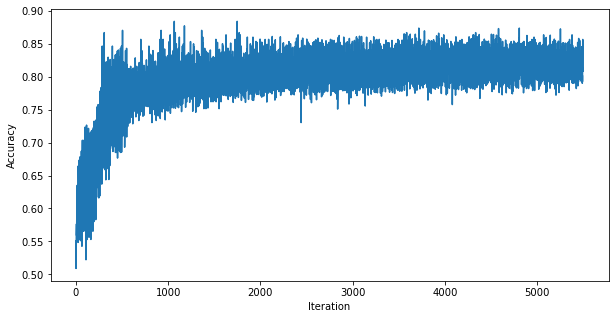

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

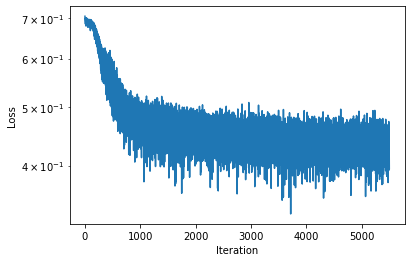

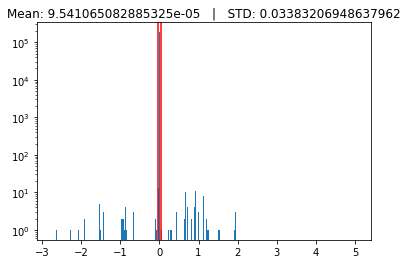

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.4


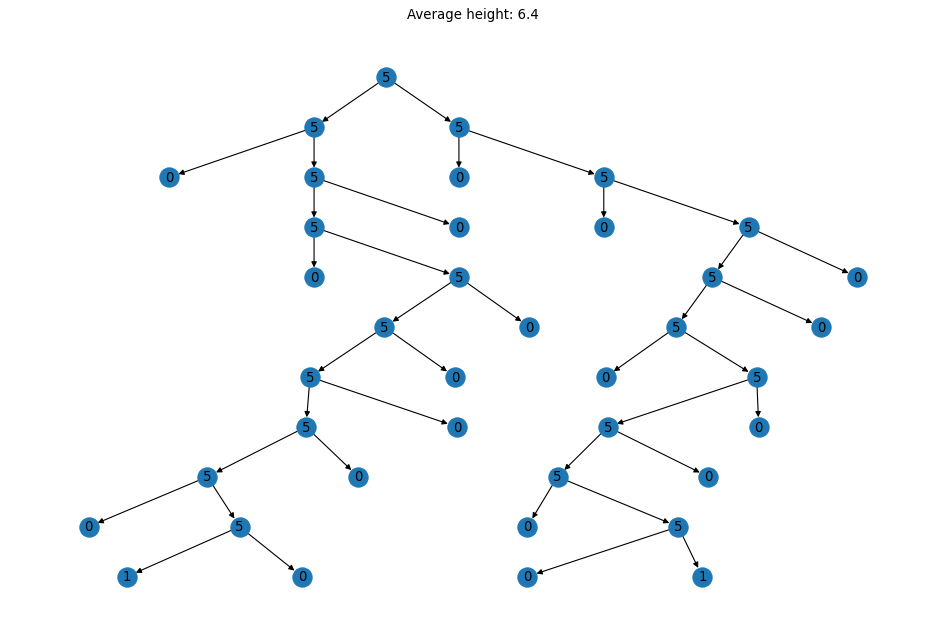

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 20


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
1036
============== Pattern 3 ==============
2696
============== Pattern 4 ==============
============== Pattern 5 ==============
3445
============== Pattern 6 ==============
5097
============== Pattern 7 ==============
3847
============== Pattern 8 ==============
1
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
4171
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
Average comprehensibility: 59.4
std comprehensibility: 26.773867856549973
var comprehensibility: 716.8399999999999
minimum comprehensibility: 16
maximum comp